In [46]:
import tensorflow as tf
import keras.layers as layers
import keras.models as models
import keras.losses as losses
import keras.callbacks as callbacks
from keras.optimizers import Adam

from typing import Dict, List, Optional, Sequence, Tuple
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi

from matplotlib import pyplot as plt
import seaborn as sns

import random

print("Tensorflow Version:", tf.__version__)

Tensorflow Version: 2.15.0


In [3]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Typical sampling rate for audio is 44.1kHz
SAMPLING_RATE = 44100

In [4]:
path = './dataset/maestro-v3.0.0'
filenames = glob.glob(f"{path}/**/*.mid*")
print("Number of files extracted:", len(filenames))

# Print out first 5 MIDI files
print("First 5 MIDI files:")
for filename in filenames[:5]:
    print(filename)

Number of files extracted: 1276
First 5 MIDI files:
./dataset/maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi
./dataset/maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi
./dataset/maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav.midi
./dataset/maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_10_Track10_wav.midi
./dataset/maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_02_Track02_wav.midi


In [5]:
sample_file = filenames[1]
print(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)

print("Number of Instruments:", len(pm.instruments))

for instrument in pm.instruments:
    instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
    print("-", instrument_name)

# Print out first 10 notes of sample
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f"{i}: pitch={note.pitch}\tnote_name={note_name}\tduration={duration:.4f}")

./dataset/maestro-v3.0.0\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi
Number of Instruments: 1
- Acoustic Grand Piano
0: pitch=31	note_name=G1	duration=0.0656
1: pitch=43	note_name=G2	duration=0.0792
2: pitch=44	note_name=G#2	duration=0.0740
3: pitch=32	note_name=G#1	duration=0.0729
4: pitch=34	note_name=A#1	duration=0.0708
5: pitch=46	note_name=A#2	duration=0.0948
6: pitch=48	note_name=C3	duration=0.6260
7: pitch=36	note_name=C2	duration=0.6542
8: pitch=53	note_name=F3	duration=1.7667
9: pitch=56	note_name=G#3	duration=1.7688


In [6]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0] # Dataset only has one instrument: Acoustic Grand Piano
    notes = collections.defaultdict(list)

    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,43,1.032292,1.111458,0.000000,0.079167
1,31,1.040625,1.106250,0.008333,0.065625
2,44,1.142708,1.216667,0.102083,0.073958
3,32,1.144792,1.217708,0.002083,0.072917
4,46,1.208333,1.303125,0.063542,0.094792


In [7]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
print(sample_note_names[:10])

['G2' 'G1' 'G#2' 'G#1' 'A#2' 'A#1' 'C3' 'C2' 'F3' 'D4']


In [8]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count != None:
        title = f'First {count} Notes'
    else:
        title = 'Whole Track'
        count = notes.shape[0]

    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)

    plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color='b', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Pitch')
    plt.title(title)
    plt.show()

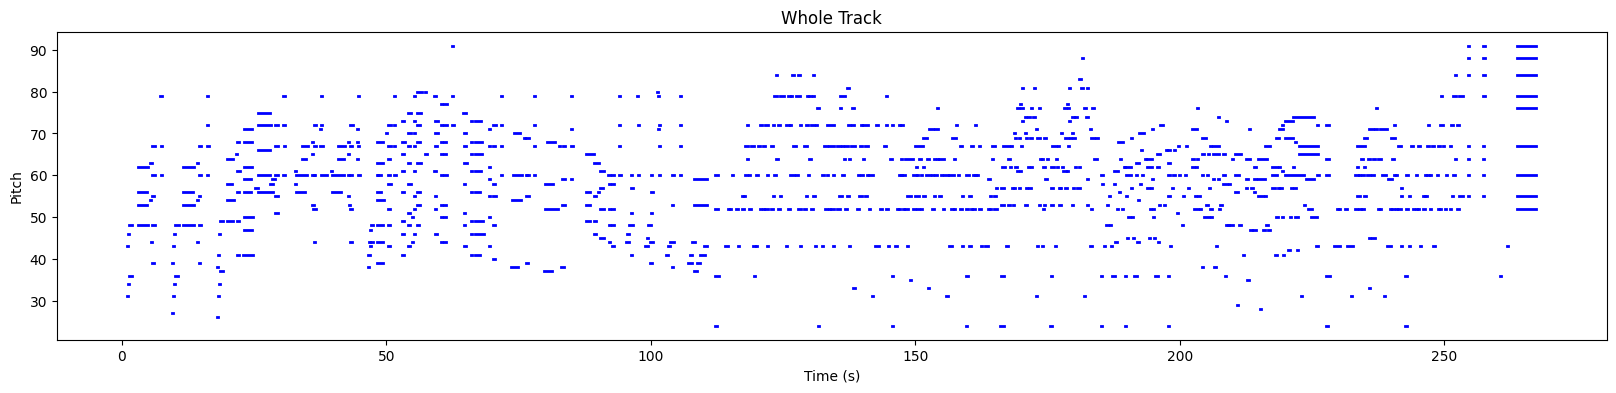

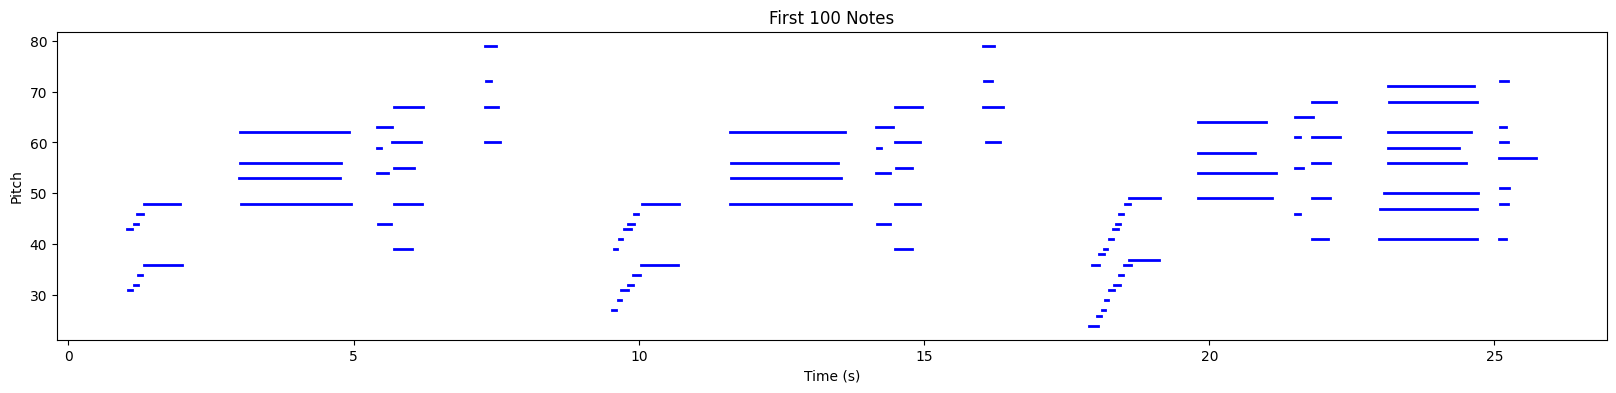

In [151]:
plot_piano_roll(raw_notes)
plot_piano_roll(raw_notes, 100)

In [9]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

print("No. of notes parsed:", len(all_notes))

key_order = ['pitch', 'step', 'duration']
train_notes = all_notes[['pitch', 'step', 'duration']].to_numpy()

notes_dataset = tf.data.Dataset.from_tensor_slices(train_notes)

# Print out Tensor shape, type and name
notes_dataset.element_spec

No. of notes parsed: 37241


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [10]:
def create_sequences(dataset: tf.data.Dataset, length: int, vocab_size: int=128) -> tf.data.Dataset:
    length += 1

    windows = dataset.window(length, shift=1, stride=1, drop_remainder=True)

    flatten = lambda x: x.batch(length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalise pitch only (dose not affect step and duration)
    def scale_pitch(x):
        x = x/[vocab_size, 1.0, 1.0]
        return x

    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key: labels_dense[i] for i, key in enumerate(key_order)}

        return (scale_pitch(inputs), labels)

    sequences = sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

    return sequences

length = 25
vocab_size = 128
sequence_dataset = create_sequences(notes_dataset, length, vocab_size)

In [11]:
batch_size = 64
buffer_size = len(notes) - length
train_dataset = (sequence_dataset
                    .shuffle(buffer_size)
                    .batch(batch_size, drop_remainder=True)
                    .cache()
                    .prefetch(tf.data.AUTOTUNE))

In [12]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [13]:
input_shape = (length, 3)
learning_rate = 0.005

inputs = layers.Input(input_shape)
x = layers.LSTM(128)(inputs)
outputs = {
    'pitch': layers.Dense(128, name='pitch')(x),
    'step': layers.Dense(1, name='step')(x),
    'duration': layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                             

In [14]:
callbacks = [callbacks.ModelCheckpoint(filepath='./training_checkpoints/ckpt_{epoch}', save_weights_only=True),
             callbacks.EarlyStopping(monitor='loss', patience=5, 
                                              verbose=1, restore_best_weights=True),]

In [15]:
# Compiling and fitting the model

loss = {
    'pitch': losses.SparseCategoricalCrossentropy(from_logits=True),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure,
}

model.compile(loss = loss, 
              loss_weights = {'pitch': 0.9, 'step': 1.0, 'duration':1.0},
              optimizer=Adam(learning_rate=learning_rate))

epochs = 50

history = model.fit(train_dataset,
                    epochs=epochs, 
                    callbacks=callbacks)

Epoch 1/50


581/581 [==============================] - 18s 23ms/step - loss: 3.6915 - duration_loss: 0.1012 - pitch_loss: 3.9393 - step_loss: 0.0449
Epoch 2/50
581/581 [==============================] - 12s 21ms/step - loss: 3.5855 - duration_loss: 0.0824 - pitch_loss: 3.8541 - step_loss: 0.0344
Epoch 3/50
581/581 [==============================] - 12s 21ms/step - loss: 3.5431 - duration_loss: 0.0814 - pitch_loss: 3.8088 - step_loss: 0.0338
Epoch 4/50
581/581 [==============================] - 14s 24ms/step - loss: 3.5070 - duration_loss: 0.0801 - pitch_loss: 3.7705 - step_loss: 0.0335
Epoch 5/50
581/581 [==============================] - 12s 21ms/step - loss: 3.4686 - duration_loss: 0.0793 - pitch_loss: 3.7285 - step_loss: 0.0337
Epoch 6/50
581/581 [==============================] - 12s 20ms/step - loss: 3.4275 - duration_loss: 0.0783 - pitch_loss: 3.6844 - step_loss: 0.0332
Epoch 7/50
581/581 [==============================] - 12s 20ms/step - loss: 3.3781 - duration_loss: 0.0773 - p

In [81]:
def predict_next_note(notes: np.ndarray, model: tf.keras.Model, 
                      temperature: float = 1.0) -> int:
    inputs = tf.expand_dims(notes, 0)
    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

In [87]:
temperature = 1.25
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# Normalise pitch
input_notes = (
    sample_notes[:length] / np.array([vocab_size, 1, 1])
)

generated_notes = []
prev_start = 0

for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration + 1.5)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

generated_notes.head(10)

1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 24ms/step


,pitch,step,duration,start,end
0,46,1.906181,1.866081,1.906181,2.272261
1,43,0.141497,1.727455,2.047677,2.275132
2,97,0.193473,1.736481,2.241150,2.477631
3,56,0.185385,1.731992,2.426535,2.658527
4,56,0.157010,1.715635,2.583545,2.799180
5,56,0.149154,1.709753,2.732699,2.942452
6,56,0.154235,1.711239,2.886934,3.098173
7,56,0.153198,1.710789,3.040132,3.250921
8,52,0.154690,1.716096,3.194822,3.410918
9,51,0.143349,1.710961,3.338171,3.549132


In [88]:
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str,
                  velocity: int = 100) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        
        note = pretty_midi.Note(velocity=velocity, pitch=int(note['pitch']),
                                start=start, end=end)
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [89]:
out_file = './out/output_8.midi'
out_pm = notes_to_midi(generated_notes, out_file=out_file, instrument_name=instrument_name)   

In [90]:
import pygame

pygame.init()

pygame.mixer.music.load('./out/output_8.midi')
pygame.mixer.music.play(fade_ms=5000)

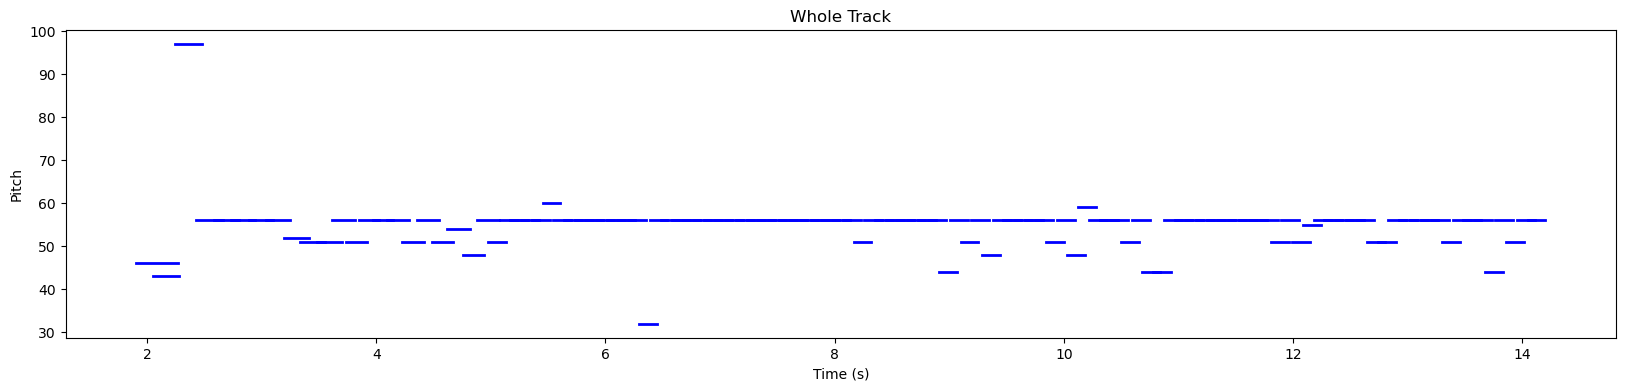

In [91]:
plot_piano_roll(generated_notes)